# **Communities Visualiztion**


## **Imports**


In [1]:
import os
import sys
from warnings import filterwarnings
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

%matplotlib inline
%load_ext autotime

load_dotenv()
filterwarnings("ignore")

module_path = os.path.abspath(os.path.join("../"))
parent_dir = os.path.dirname(os.getcwd())
if module_path not in sys.path:
    sys.path.append(module_path)

time: 2.66 ms (started: 2022-12-31 00:32:41 -05:00)


In [26]:
import tweepy
import numpy as np
import pandas as pd
import dask.dataframe as dd
import ast
from scipy.stats import gmean
import networkx as nx
import seaborn as sns
from utils.graph import get_ego_graph, draw_nx_graph, draw_plotly_graph

PATH = os.getcwd()
PROJECT = str(Path(PATH).parents[0])
TWITTER_USERNAME = os.getenv("TWITTER_USERNAME")
TWITTER_API_KEY = os.getenv("TWITTER_API_KEY")
TWITTER_API_SECRET = os.getenv("TWITTER_API_SECRET")
TWITTER_API_BEARER_TOKEN = os.getenv("TWITTER_API_BEARER_TOKEN")
CLOUD_STORAGE_BUCKET = os.getenv("CLOUD_STORAGE_BUCKET")
TWITTER_USERNAME=os.getenv("TWITTER_USERNAME")
TWITTER_USER_ID=os.getenv("TWITTER_FOCAL_NODE_ID")

client = tweepy.Client(TWITTER_API_BEARER_TOKEN, wait_on_rate_limit=True)

time: 1.77 ms (started: 2022-12-31 00:42:51 -05:00)


## **Read**


### **Node Centrality (Subset)**


In [123]:
df_cen = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/measures/node/node_measures.csv").compute()
print(df_cen.shape)
df_cen.head()

(1117046, 3)


,measure_name,node,measure_value
0,pagerank,44196397,0.000015
1,pagerank,433365936,0.000012
2,pagerank,2248872301,0.000012
3,pagerank,35761106,0.000012
4,pagerank,1542483269542940679,0.000012


time: 4.73 s (started: 2022-12-31 15:24:59 -05:00)


In [129]:
df[df.user==1427408443296657408]

,user,following
228,1427408443296657408,62513246
228,1427408443296657408,859816394556284929
228,1427408443296657408,20601296
228,1427408443296657408,1105508110213545984
228,1427408443296657408,235348644
...,...,...
228,1427408443296657408,3289153303
228,1427408443296657408,823518894182846464
228,1427408443296657408,753617640355012608
228,1427408443296657408,4398626122


time: 5.33 ms (started: 2022-12-31 15:26:29 -05:00)


### **Node Features**


In [125]:
nodes = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/features/node/node_features*.csv", dtype={'withheld': 'object'}).compute()
print(nodes.shape)
nodes.head()

(206090, 7)


,id,name,profile_image_url,public_metrics,username,verified,withheld
0,794433401591693312,Aran Komatsuzaki,https://pbs.twimg.com/profile_images/150798283...,"{'followers_count': 16111, 'following_count': ...",arankomatsuzaki,False,NaN
1,2509504696,Jericho Brown,https://pbs.twimg.com/profile_images/111968593...,"{'followers_count': 40468, 'following_count': ...",jerichobrown,True,NaN
2,1938030980,Angel Wicky,https://pbs.twimg.com/profile_images/144139505...,"{'followers_count': 355162, 'following_count':...",Angel_Wicky_II,True,NaN
3,335544910,AC Justice Project,https://pbs.twimg.com/profile_images/145415812...,"{'followers_count': 1049, 'following_count': 4...",ACJProject,False,NaN
4,2622261,Brian Ulicny,https://pbs.twimg.com/profile_images/730781652...,"{'followers_count': 796, 'following_count': 24...",bulicny,False,NaN


time: 6.23 s (started: 2022-12-31 15:25:31 -05:00)


### **Graph**


In [5]:
df = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/ties/ties*.csv").compute()
df.following = df.following.apply(ast.literal_eval)
df = df.explode('following')

#if you need a full graph including the user
user = client.get_user(
    username=TWITTER_USERNAME,
    user_fields=["id"],
).data.id
df_following = df.copy().dropna()
df_user = pd.DataFrame({"user": user, "following": df_following.user.unique()})
df_with_user = pd.concat([df_user, df_following])

#create  a graph
edges = df_with_user.copy().dropna()
edges.columns = ['source', 'target']
edges['source'] = edges['source'].astype(int)
edges['target'] = edges['target'].astype(int)
edges['weight'] = 1
print(df.shape, edges.shape)

G = nx.from_pandas_edgelist(
    edges,
    create_using=nx.DiGraph(),
    edge_attr=True
)
print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")
df.head()

(239795, 2) (240033, 3)
Nodes: 159578, Edges: 237327


,user,following
0,12,69170362
0,12,1499167615121387522
0,12,594103
0,12,58868301
0,12,721049861399949313


time: 5.45 s (started: 2022-12-31 00:33:22 -05:00)


In [18]:
c_s = list(nx.strongly_connected_components(G))
c_s.sort(key=len, reverse=True)

time: 964 ms (started: 2022-12-31 00:38:04 -05:00)


## **Statuses & Retweets**

In [20]:
def authenticate(api_bearer_token):
    import tweepy

    client = tweepy.Client(api_bearer_token, wait_on_rate_limit=True)
    return client


def get_users(client, user_fields, user_names=None, user_ids=None):

    if user_ids:
        return client.get_users(
            ids=user_ids,
            user_fields=user_fields,
        ).data
    elif user_names:
        return client.get_users(
            usernames=user_names,
            user_fields=user_fields,
        ).data
    else:
        raise ValueError(
            "Either one of user_names or user_ids should be provided"
        )
def get_users_following(
    client, user_id, max_results=1000, total_limit=5000, sleep_time=0.1
):
    import tweepy

    following = []
    for neighbor in tweepy.Paginator(
        client.get_users_following, id=user_id, max_results=max_results
    ).flatten(limit=total_limit):
        time.sleep(sleep_time)
        following.append(neighbor.id)
    print(f"User: {user_id}, Following: {len(following)}")
    return {"user": user_id, "following": following}

time: 1.42 ms (started: 2022-12-31 00:41:57 -05:00)


In [28]:
import time
user_d1_nodes = get_users_following(client, user_id=TWITTER_USER_ID)
len(user_d1_nodes.get('following'))

User: 1427408443296657408, Following: 241


241

time: 24.4 s (started: 2022-12-31 00:43:10 -05:00)


In [65]:
nodes.sample(5)

,id,name,profile_image_url,public_metrics,username,verified,withheld
125108,850892377627742209,Tyler Derr,https://pbs.twimg.com/profile_images/133466196...,"{'followers_count': 1034, 'following_count': 9...",TylersNetwork,False,NaN
198490,998327796672811008,ClarkeMD,https://pbs.twimg.com/profile_images/998329452...,"{'followers_count': 46398, 'following_count': ...",MdTeryn,False,NaN
90508,2413696970,Technoblade,https://pbs.twimg.com/profile_images/128495990...,"{'followers_count': 3587760, 'following_count'...",Technothepig,True,NaN
105876,759140784180457472,Neeraj Salvankar,https://pbs.twimg.com/profile_images/151260896...,"{'followers_count': 72, 'following_count': 215...",neerajsal1kar,False,NaN
104531,198588215,Optimus Prime,https://pbs.twimg.com/profile_images/146904969...,"{'followers_count': 678, 'following_count': 50...",TemporalAnalyst,False,NaN


time: 7.77 ms (started: 2022-12-31 01:14:24 -05:00)


In [36]:
# test_users= user_d1_nodes.get('following')
test_users = [1938030980]#, 1433718835127926787, 2465283662]
def get_content_type(
                    user_id, 
                     content_type = "tweets", 
                     tweet_fields=['context_annotations','in_reply_to_user_id','public_metrics','entities','created_at']):
    if content_type == "tweets":
        return client.get_users_tweets(id=user_id, tweet_fields=tweet_fields).data
    elif content_type == "mentions":
        return client.get_users_mentions(id=user_id, tweet_fields=tweet_fields).data
    elif content_type == "likes":
        return client.get_liked_tweets(id=user_id, tweet_fields=tweet_fields).data
    
d = get_content_type(user_id=test_users[0], content_type="tweets")
d

[<Tweet id=1608402302234234880 text='Join me by the pool 😎\n\n#italy #travelblogger #traveler #traveling #travelling #traveler #travellife #europe #europeunion #europeanart #milan #milano #roma #rome #vacation #vacations #Italian #playboy #fhm #magazine https://t.co/UsrcBSeWw2'>,
 <Tweet id=1606560242917056512 text='Wishing you beautiful and peaceful Christmas filled with love 🤗❤️🎄🎁\nPřeji vám krásné a klidně Vánoce plné lásky 🤗❤️🎄🎁\n\n#christmas #Christmasgifts #MerryChristmas #horsegirl #horses #horse #horselover #horselovers #horsetrainer #animallover #rescueanimal https://t.co/6NypbtN2Aw'>,
 <Tweet id=1606408122142269463 text='Christmas liveshow is coming this Sunday!😎🤶🎄🎁\nFrom 9pm cet at https://t.co/Od0lp4hwNh @SecretFriendsX https://t.co/WKyaYdSnnL'>,
 <Tweet id=1605634142309318666 text='I’ve been asked what I want for Christmas, new year, birthday etc… ?? https://t.co/jCW8BKies7'>,
 <Tweet id=1605523356802916354 text='MUST SEE! Double penetration for Christmas 😱😎🍆🍆😜😋💦💦 Watch it

time: 233 ms (started: 2022-12-31 00:49:29 -05:00)


In [116]:
# test_users= user_d1_nodes.get('following')
content_df = pd.DataFrame()

for c in ["tweets", "mentions", "likes"]:
    time.sleep(0.5)
    for i, test_user in enumerate(test_users[:5]):
        print(f"users:{i}/{len(test_users)}")
        if i%100==0:
            time.sleep(10)
        data = get_content_type(user_id=test_user, content_type=c)
        try:
            for d in data:  
                content_df = content_df.append({
                                                        "user_id": test_user,
                                                        "timestamp": d.created_at,
                                                        "tweet_id": d.id,
                                                        "content": c,
                                                        "public_metrics": d.public_metrics,
                                                        "in_reply_to_user_id":d.in_reply_to_user_id,
                                                        "hashtags": [h.get('tag') for h in d.get('entities').get('hashtags', ())],
                                                        "context": [t.get('entity', ()).get('name').lower() for t in d.context_annotations]}, ignore_index=True)
        except:
            continue
    print(f"{c}: {content_df.shape}")
print(f"{c}: {content_df.shape}")
content_df.to_csv(f"data/tie_features_{time.strftime('%Y%m%d')}.csv", index=False) #%H%M%S
content_df.tail(10)

users:0/241
users:1/241
users:2/241
users:3/241
users:4/241
tweets: (34, 8)
users:0/241
users:1/241
users:2/241
users:3/241
users:4/241
mentions: (82, 8)
users:0/241
users:1/241
users:2/241
users:3/241
users:4/241
likes: (257, 8)
likes: (257, 8)


,user_id,timestamp,tweet_id,content,public_metrics,in_reply_to_user_id,hashtags,context
247,1067218780806307841,2022-09-21 22:41:31+00:00,1572717691219345408,likes,"{'retweet_count': 5, 'reply_count': 5, 'like_c...",None,"[PostdocJEDIChampions22, StanfordAIMI]","[entertainment & leisure business, star wars, ..."
248,1067218780806307841,2022-09-21 18:33:47+00:00,1572655345075638275,likes,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1067218780806307841,[],"[midjourney, digital artwork, ai image generat..."
249,1067218780806307841,2022-09-21 18:27:35+00:00,1572653783850840064,likes,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1067218780806307841,[],[]
250,1067218780806307841,2022-09-19 22:43:29+00:00,1571993409694609408,likes,"{'retweet_count': 6, 'reply_count': 0, 'like_c...",None,[NLProc],[technology business]
251,1067218780806307841,2022-09-20 04:07:07+00:00,1572074854459019265,likes,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1239836152418299904,[],[]
252,1067218780806307841,2022-09-20 04:03:23+00:00,1572073913391394816,likes,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1067218780806307841,[],[]
253,1067218780806307841,2022-09-19 14:58:20+00:00,1571876349169508352,likes,"{'retweet_count': 10, 'reply_count': 1, 'like_...",None,[],[]
254,1067218780806307841,2022-09-14 02:33:12+00:00,1569876891338969090,likes,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",None,[],"[technology business, economics]"
255,1067218780806307841,2022-09-16 00:56:16+00:00,1570577273857929217,likes,"{'retweet_count': 10, 'reply_count': 0, 'like_...",None,[],"[stanford university, stanford university, gov..."
256,1067218780806307841,2022-09-15 20:51:45+00:00,1570515737856577536,likes,"{'retweet_count': 100, 'reply_count': 5, 'like...",None,[],[]


time: 40.5 s (started: 2022-12-31 11:12:33 -05:00)


In [98]:
content_df_all = pd.concat([pd.read_csv(f"data/{c}_{time.strftime('%Y%m%d')}.csv") for c in ["tweets", "mentions", "likes"]], ignore_index=True)
content_df_all.in_reply_to_user_id = content_df_all.in_reply_to_user_id.fillna(0.0).astype(int)
print(content_df_all.shape)
content_df_all.head()

(259, 8)


,user_id,timestamp,tweet_id,content,public_metrics,in_reply_to_user_id,hashtags,context
0,3289153303,2022-12-30 19:40:48+00:00,1608910996969754624,tweets,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",2738381,[],"['financial services business', 'travel & tran..."
1,3289153303,2022-12-30 19:32:23+00:00,1608908877877370880,tweets,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",650733,[],"['transportation', 'automotive, aircraft & boa..."
2,3289153303,2022-12-30 19:05:19+00:00,1608902065933410305,tweets,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",905201,[],[]
3,3289153303,2022-12-30 18:59:53+00:00,1608900699773100033,tweets,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",650733,[],"['transportation', 'automotive, aircraft & boa..."
4,3289153303,2022-12-30 18:53:29+00:00,1608899091022647296,tweets,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1584642529,[],['andrew tate']


time: 12.1 ms (started: 2022-12-31 01:33:10 -05:00)


In [119]:
content_df_all[(content_df_all.user_id != content_df_all.in_reply_to_user_id) & (content_df_all.in_reply_to_user_id != 0)] \
    .groupby(["user_id", "in_reply_to_user_id"]) \
    .tweet_id \
    .count()\
    .reset_index() \
    .rename(columns={'user_id': 'source','in_reply_to_user_id': 'target', 'tweet_id': 'weight', }).head()

,source,target,weight
0,19725644,13445732,1
1,19725644,31039201,1
2,19725644,38361272,1
3,19725644,39439838,1
4,19725644,44196397,3


time: 8.9 ms (started: 2022-12-31 15:01:26 -05:00)


In [105]:
nodes[nodes.id.isin([19725644, 175624200, 44196397, 18676154, 130745589])]

,id,name,profile_image_url,public_metrics,username,verified,withheld
1956,175624200,John Carmack,https://pbs.twimg.com/profile_images/110649778...,"{'followers_count': 953883, 'following_count':...",ID_AA_Carmack,True,NaN
48066,44196397,Elon Musk,https://pbs.twimg.com/profile_images/150359143...,"{'followers_count': 81133488, 'following_count...",elonmusk,True,NaN
56906,18676154,Shawn Presser,https://pbs.twimg.com/profile_images/107744830...,"{'followers_count': 4739, 'following_count': 2...",theshawwn,False,NaN
64968,19725644,Neil deGrasse Tyson,https://pbs.twimg.com/profile_images/74188698/...,"{'followers_count': 14622136, 'following_count...",neiltyson,True,NaN
84489,130745589,Fei-Fei Li,https://pbs.twimg.com/profile_images/841385099...,"{'followers_count': 397370, 'following_count':...",drfeifei,True,NaN


time: 9.02 ms (started: 2022-12-31 01:36:09 -05:00)


In [85]:
tweets = client.get_users_mentions(id=test_user, tweet_fields=['context_annotations','created_at','geo'])

for tweet in tweets.data:
    # print(tweet)
    context = set([t.get('entity').get('name')for t in tweet.context_annotations])
print(context)

{'Automotive, Aircraft & Boat Business', 'Luxury Cars', 'Design', 'Automotive', 'Tesla Motors', 'Hybrid and electric vehicles', 'Auto Manufacturer - Auto', 'Automobile Brands'}
time: 355 ms (started: 2022-12-31 01:18:35 -05:00)


In [316]:
tweets_dataframe.groupby(['user_id', 'content']).tweet_id.count()

user_id              content 
1938030980           likes       95
                     mentions    10
                     tweets      10
2465283662           likes       99
                     mentions    10
                     tweets      10
1433718835127926787  likes       43
                     mentions    10
                     tweets      10
Name: tweet_id, dtype: int64

time: 10.9 ms (started: 2022-12-04 21:54:28 -05:00)


In [113]:
alters = {
            i: {"previous": set(), "current": set(), "new": set()}
            for i in range(1, 2 + 1)
        }
alters[1]["previous"] = set([1,2,7])
alters[1]["previous"] = alters.get(1).get("previous").difference(set([7]))
alters

{1: {'previous': {1, 2}, 'current': set(), 'new': set()},
 2: {'previous': set(), 'current': set(), 'new': set()}}

time: 2.81 ms (started: 2022-12-31 10:07:44 -05:00)


In [117]:
content = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/features/ties/*.csv").compute()
content.head()

,user_id,content,timestamp,tweet_id,public_metrics,in_reply_to_user_id,hashtags,context
0,1034954029896355840,tweets,2022-12-30 05:48:45+00:00,1608701605326749696,"{'retweet_count': 8, 'reply_count': 0, 'like_c...",NaN,[],"['government/education', 'education related - ..."
1,1034954029896355840,tweets,2022-12-30 05:43:51+00:00,1608700371886804993,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",NaN,[],"['publisher & news business', 'the new york ti..."
2,1034954029896355840,tweets,2022-12-30 00:56:27+00:00,1608628045921026048,"{'retweet_count': 11, 'reply_count': 0, 'like_...",NaN,[],"['publisher & news business', 'time magazine',..."
3,1034954029896355840,tweets,2022-12-29 21:18:51+00:00,1608573283175395334,"{'retweet_count': 0, 'reply_count': 2, 'like_c...",1.034954e+18,[],[]
4,1034954029896355840,tweets,2022-12-29 21:18:50+00:00,1608573281598062592,"{'retweet_count': 3, 'reply_count': 1, 'like_c...",1.034954e+18,[],[]


time: 1.39 s (started: 2022-12-31 13:25:22 -05:00)


In [122]:
print(content.shape)
_ = content[(content.user_id != content.in_reply_to_user_id) & (content.in_reply_to_user_id != 0)] \
    .groupby(["user_id", "in_reply_to_user_id"]) \
    .tweet_id \
    .count()\
    .reset_index() \
    .rename(columns={'user_id': 'source','in_reply_to_user_id': 'target', 'tweet_id': 'weight', })
print(_.shape)
_.head()

(13166, 8)
(2034, 3)


,source,target,weight
0,12,22.0,1
1,12,9918032.0,1
2,12,16158749.0,1
3,12,31139034.0,1
4,12,147627379.0,1


time: 11.1 ms (started: 2022-12-31 15:02:09 -05:00)


{0: 2.6666666666666665,
 1: 2.6666666666666665,
 2: 2.6666666666666665,
 3: 9.5,
 4: 20.0,
 5: 9.5,
 6: 2.6666666666666665,
 7: 2.6666666666666665,
 8: 2.6666666666666665}

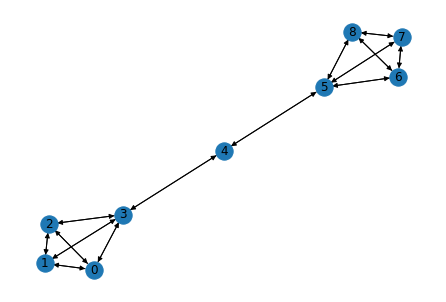

time: 165 ms (started: 2022-12-31 16:19:21 -05:00)


In [185]:
def brokerage(graph, k=500, seed=42):
    from networkx import edge_betweenness_centrality
    from pandas import Series

    e_cen = edge_betweenness_centrality(
        graph,
        k=min(graph.number_of_nodes(), k),
        seed=seed,
        normalized=False,
        weight="weight",
    )
    measure = (
        Series(e_cen)
        .rename_axis(["source", "target"])
        .reset_index(name="measure_value")
        .groupby("source").measure_value.mean().to_dict()
    )
    return measure

G_b = nx.barbell_graph(m1 = 4, m2 = 1).to_directed()
nx.draw(G_b, with_labels = True)
m_ = brokerage(G_b)
m_

{0: 1.6666666666666667,
 1: 1.6666666666666667,
 2: 1.6666666666666667,
 3: 4.25,
 4: 6.5,
 5: 5.0}

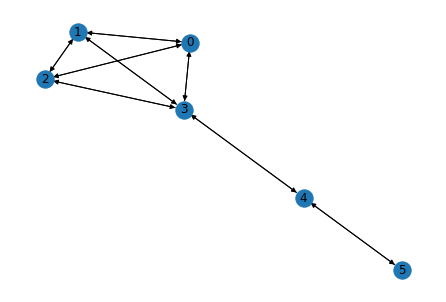

time: 121 ms (started: 2022-12-31 16:18:51 -05:00)


In [183]:
G_b = nx.lollipop_graph(m = 4, n = 2).to_directed()
nx.draw(G_b, with_labels = True)
m_ = brokerage(G_b)
m_